# COCS2673 Assignment 2 P1A - Is or is not cancel prediction

In [1]:
# !pip install tensorflow

In [2]:
# import zipfile
# with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#    zip_ref.extractall('./')

In [3]:
#!pwd

In [4]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

import pandas as pd

tf.__version__

'2.4.1'

## Tasks
### Load Data
Split data into train, validation, and test
Note that images for the same patient may contain a mix of cancerous and non-cancerous data.
Q - Sould we split on patient or just randomly

### Measure 
As this is a screening task, the impact of a false negative is high (ie someone who has cancer is missed)
In this case use Recall for measure.
We can also use F1 to get a more balanced measure of Precision and Recall

In [5]:
mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')

In [6]:
#mainData = mainData.append(extraData, ignore_index=True)
mainData = mainData.sample(2000)


In [7]:
print(mainData.shape)
print(mainData.info())
print(mainData.describe())


(2000, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 2473 to 1121
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    2000 non-null   int64 
 1   patientID     2000 non-null   int64 
 2   ImageName     2000 non-null   object
 3   cellTypeName  2000 non-null   object
 4   cellType      2000 non-null   int64 
 5   isCancerous   2000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 109.4+ KB
None
        InstanceID    patientID     cellType  isCancerous
count   2000.00000  2000.000000  2000.000000  2000.000000
mean   10256.47550    30.125500     1.508500     0.406000
std     6632.49876    17.510199     0.958325     0.491207
min        2.00000     1.000000     0.000000     0.000000
25%     4160.75000    14.000000     1.000000     0.000000
50%     9347.00000    29.000000     2.000000     0.000000
75%    16767.25000    47.000000     2.000000     1.000000
max    22442.00000    60

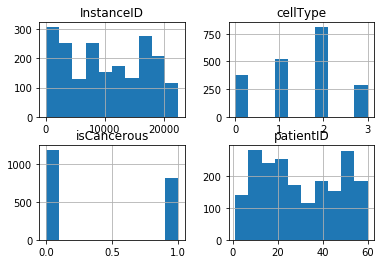

In [8]:
mainData.hist()
plt.show()

In [9]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 2473 to 1121
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    2000 non-null   int64 
 1   patientID     2000 non-null   int64 
 2   ImageName     2000 non-null   object
 3   cellTypeName  2000 non-null   object
 4   cellType      2000 non-null   int64 
 5   isCancerous   2000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 109.4+ KB


In [10]:
pd.isna(mainData).sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

In [11]:
for i, col in enumerate(mainData.columns):
    print("==>", col)
    print(mainData[col].value_counts())
    print()

==> InstanceID
18431    1
15781    1
4897     1
5602     1
15761    1
        ..
13703    1
4881     1
17173    1
4887     1
12288    1
Name: InstanceID, Length: 2000, dtype: int64

==> patientID
54    89
29    74
9     74
17    69
8     66
10    58
18    56
40    52
55    52
20    51
23    50
41    50
21    49
24    46
14    46
51    45
49    43
7     41
43    41
6     39
26    38
5     36
33    35
48    34
57    34
52    34
50    34
25    34
13    33
58    32
12    32
42    32
53    31
19    30
22    27
3     27
4     27
59    26
32    26
31    25
36    25
47    24
15    24
46    23
60    23
30    22
39    22
44    21
56    18
37    15
38    14
16    12
11    10
45    10
2      7
1      5
34     4
27     1
28     1
35     1
Name: patientID, dtype: int64

==> ImageName
3598.png     1
3169.png     1
13418.png    1
3160.png     1
13377.png    1
            ..
3172.png     1
11312.png    1
4910.png     1
4059.png     1
16633.png    1
Name: ImageName, Length: 2000, dtype: int64

==> cellT

In [12]:
extraData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  int64 
 1   patientID    10384 non-null  int64 
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 324.6+ KB


In [13]:
pd.isna(extraData).sum()

InstanceID     0
patientID      0
ImageName      0
isCancerous    0
dtype: int64

Check all image files exist

In [14]:
import glob

image_list = set()
for filepath in glob.glob('./patch_images/*', recursive=True): #assuming gif
    filename = filepath.split("\\")[-1]
    image_list.add(filename)
    
print(len(image_list))

20280


In [15]:
mainData.append(extraData, ignore_index=True)


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,3195,14,3195.png,epithelial,2.0,1
1,17766,59,17766.png,others,3.0,0
2,9425,21,9425.png,epithelial,2.0,1
3,11837,30,11837.png,epithelial,2.0,1
4,3191,14,3191.png,epithelial,2.0,1
...,...,...,...,...,...,...
12379,20028,99,20028.png,NaN,NaN,0
12380,20029,99,20029.png,NaN,NaN,0
12381,20030,99,20030.png,NaN,NaN,0
12382,20031,99,20031.png,NaN,NaN,0


# Train/Validation/Test Split on Patients

For test and training data split via person.
- Check if a person has cancer or not, then would the images for that person have cancer?

In [16]:
# Get list of patients and observation counts
TEST_RATIO = 0.10
VAL_RATIO = 0.15


In [17]:
np.random.seed(43) # Consistent random list

recCount = mainData.shape[0]
custRec = mainData.patientID.value_counts().to_dict()
    
patientIds = list(custRec.keys())
    
testCust = []
testRecs = 0
while (testRecs < (recCount * TEST_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    testCust.append(pId)
    testRecs += ic
    
#print(testCust, testRecs)

valCust = []
valRecs = 0
while (valRecs < (recCount * VAL_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    valCust.append(pId)
    valRecs += ic

#print(valCust, valRecs)

In [18]:
testData = mainData[mainData.patientID.isin(testCust)]
valData = mainData[mainData.patientID.isin(valCust)]
trainData = mainData[~(mainData.patientID.isin(valCust + testCust))]

In [19]:
#print(trainData.shape[0] + valData.shape[0] + testData.shape[0])
#print(mainData.shape[0])
print("Train data : {}, Val Data: {}, Test Data: {}".format(trainData.shape[0], valData.shape[0], testData.shape[0]))

Train data : 1477, Val Data: 322, Test Data: 201


### Add classification class

In [20]:
trainData['Class'] = trainData['isCancerous'].astype('str')
valData['Class'] = valData['isCancerous'].astype('str')
testData['Class'] = testData['isCancerous'].astype('str')

C:\bin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\bin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\bin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [21]:
trainData.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,Class
2473,3195,14,3195.png,epithelial,2,1,1
3997,9425,21,9425.png,epithelial,2,1,1
5475,11837,30,11837.png,epithelial,2,1,1
2469,3191,14,3191.png,epithelial,2,1,1
5639,11277,32,11277.png,fibroblast,0,0,0


# Images
27x27 RGB 

In [22]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 1

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=valData,
        directory='patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 1477 validated image filenames belonging to 2 classes.
Found 322 validated image filenames belonging to 2 classes.


# Models

In [24]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


In [26]:
# model.compile(optimizer='SGD',
#              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#              metrics=['categorical_accuracy'])

#model.compile(optimizer='adam',
#              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#              metrics=[tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['binary_accuracy'])

In [27]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

22:16:42


C:\bin\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


22:18:25
Took =  0:01:43.554589


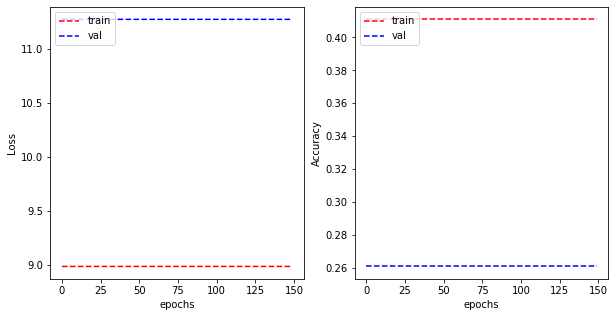

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['binary_accuracy'], 'r--')
plt.plot(history.history['val_binary_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

# Try some regularisation

In [31]:
reg_lambda = 0.01

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [35]:
model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [36]:
model_reg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


In [37]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_reg = model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)


22:22:04
22:24:22
Took =  0:02:17.532780


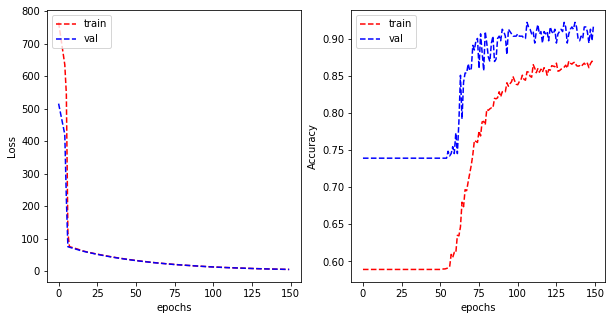

In [39]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_reg.history['binary_accuracy'], 'r--')
plt.plot(history_reg.history['val_binary_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

# Try some dropout

In [40]:
reg_lambda = 0.01

model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [41]:
model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [42]:
model_drop.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               560128    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


In [43]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

22:25:28


C:\bin\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


22:27:31
Took =  0:02:03.232859


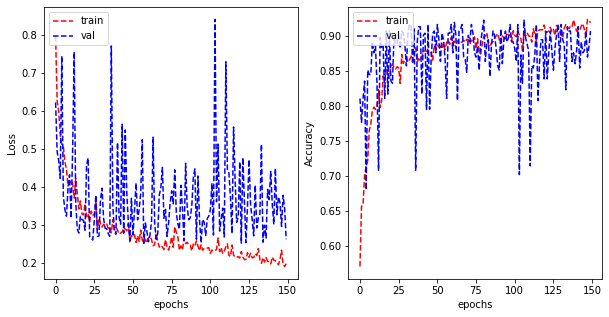

In [44]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_drop.history['loss'], 'r--')
plt.plot(history_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_drop.history['binary_accuracy'], 'r--')
plt.plot(history_drop.history['val_binary_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')

plt.show()
